## Data Loading

In [1]:
from DecisionTree import DecisionTree
from CrossValidator import KFoldCrossValidator
from TreeEvaluator import TreeEvaluator
import numpy as np

## Loading datasets
clean_data = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_data = np.loadtxt('wifi_db/noisy_dataset.txt')

## Last column is the label, which we should convert to int
clean_labels = clean_data[:, -1].astype(int)
noisy_labels = noisy_data[:, -1].astype(int)

clean_data = np.column_stack((clean_data[:, :-1], clean_labels))
noisy_data = np.column_stack((noisy_data[:, :-1], noisy_labels))

## check shape, we expect these to be the same
print(f"Clean data shape: {clean_data.shape}")
print(f"Noisy data shape: {noisy_data.shape}")

print(f"First row of clean data: {clean_data[0]}")
print(f"First row of noisy data: {noisy_data[0]}")

Clean data shape: (2000, 8)
Noisy data shape: (2000, 8)
First row of clean data: [-64. -56. -61. -66. -71. -82. -81.   1.]
First row of noisy data: [-59. -53. -51. -54. -45. -79. -87.   4.]


## Train Tree on Full Dataset

In [2]:
## We expect the tree to achieve 100% accuracy on the provided training data
tree = DecisionTree(clean_data)
tree.train(max_depth=None) # No max depth, fully grow the tree
avg_acc = TreeEvaluator.evaluate(clean_data, tree)
assert avg_acc == 1.0, f"Expected 100% accuracy on clean training data but got {avg_acc}"
print(f"Tree achieved 100% accuracy on training data.\nTree depth on clean data: {tree.depth}")

Tree achieved 100% accuracy on training data.
Tree depth on clean data: 14


## Visualise Tree Structure

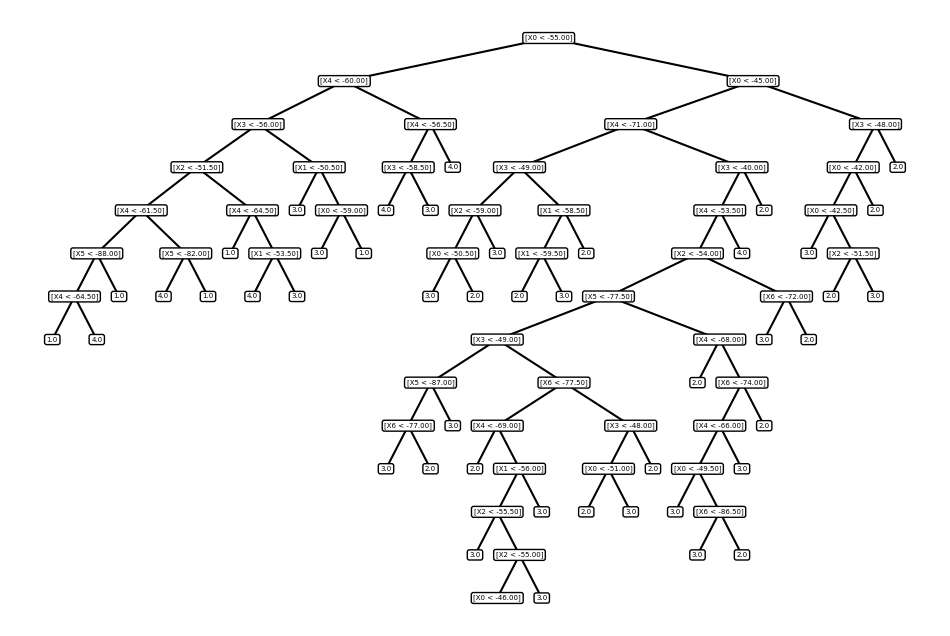

In [8]:
plt = tree.visualise(1, tree.depth)
plt.show()

## 10 Fold Cross Validation

In [13]:
tenFoldValidator = KFoldCrossValidator(DecisionTree, 10)

def process_metrics(metrics):
    # calculate precision, recall, f1 from confusion matrix
    confusion_matrix = metrics["avg_confusion_matrix"]
    label_to_index = metrics["label_to_index"]
    precision_dict, recall_dict= TreeEvaluator.get_precision_recall_per_class(
        confusion_matrix, label_to_index)
    per_label_f1 = {}
    for label in label_to_index.keys():
        f1 = TreeEvaluator.get_f1_score(precision_dict[label], recall_dict[label])
        per_label_f1[label] = f1
    metrics["precision"] = precision_dict
    metrics["recall"] = recall_dict
    metrics["f1_score"] = per_label_f1

## We expect the accuracies here to be different each time due to randomness in fold splitting
print("Performing 10-Fold Cross Validation on clean data:")
clean_metrics = tenFoldValidator.k_fold_cross_validation(clean_data)
process_metrics(clean_metrics)
print("Average Accuracy on clean data:", clean_metrics["average_accuracy"])

# Python's maximum recursion depth is usually 1000
# The tree could sometimes exceed this depth on noisy data, leading to a RecursionError
# So we set a max depth of 1000 for noisy data
print("\nPerforming 10-Fold Cross Validation on noisy data:")
noisy_metrics = tenFoldValidator.k_fold_cross_validation(noisy_data, tree_depth=1000)
process_metrics(noisy_metrics)
print("Average Accuracy on noisy data:", noisy_metrics["average_accuracy"])

Performing 10-Fold Cross Validation on clean data:
Fold 1: Accuracy = 0.9800
Fold 2: Accuracy = 0.9500
Fold 3: Accuracy = 0.9800
Fold 4: Accuracy = 0.9750
Fold 5: Accuracy = 0.9750
Fold 6: Accuracy = 0.9850
Fold 7: Accuracy = 0.9750
Fold 8: Accuracy = 0.9800
Fold 9: Accuracy = 0.9900
Fold 10: Accuracy = 0.9750
Average Accuracy on clean data: 0.9765

Performing 10-Fold Cross Validation on noisy data:
Fold 1: Accuracy = 0.8000
Fold 2: Accuracy = 0.7800
Fold 3: Accuracy = 0.7650
Fold 4: Accuracy = 0.8000
Fold 5: Accuracy = 0.7950
Fold 6: Accuracy = 0.8000
Fold 7: Accuracy = 0.8200
Fold 8: Accuracy = 0.8100
Fold 9: Accuracy = 0.7900
Fold 10: Accuracy = 0.8350
Average Accuracy on noisy data: 0.7995000000000001


## Result Visualisation

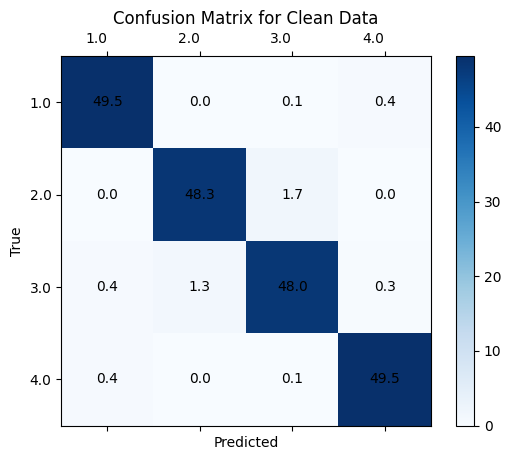

Results Summary for Clean Data:
Average Accuracy: 0.9765
Precision per class:
  Class 1: 0.9840954274353877
  Class 2: 0.9737903225806452
  Class 3: 0.9619238476953909
  Class 4: 0.9860557768924302
F1 Score per class:
  Class 1: 0.9870388833499502
  Class 2: 0.9698795180722892
  Class 3: 0.960960960960961
  Class 4: 0.9880239520958083



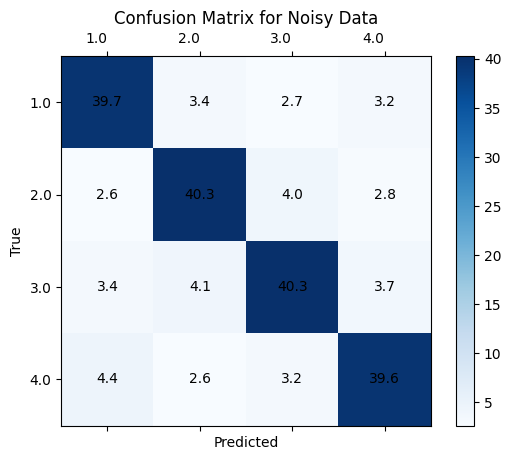

Results Summary for Noisy Data:
Average Accuracy: 0.7995000000000001
Precision per class:
  Class 1: 0.7924151696606787
  Class 2: 0.7996031746031745
  Class 3: 0.8027888446215139
  Class 4: 0.8032454361054767
F1 Score per class:
  Class 1: 0.8012108980827447
  Class 2: 0.8051948051948051
  Class 3: 0.7925270403146509
  Class 4: 0.7991927346115036



In [23]:
import matplotlib.pyplot as plt

def visualise_confusion_matrix(confusion_matrix, label_to_index, title):
    labels = list(label_to_index.keys())
    
    fig, ax = plt.subplots()
    cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, confusion_matrix[i, j],
                    ha="center", va="center", color="black")
    
    plt.show()

def get_results_summary(metrics, dataset_type):
    summary = f"Results Summary for {dataset_type} Data:\n"
    summary += f"Average Accuracy: {metrics['average_accuracy']}\n"
    summary += "Precision per class:\n"
    for label, precision in metrics["precision"].items():
        summary += f"  Class {int(label)}: {precision}\n"
    summary += "F1 Score per class:\n"
    for label, f1 in metrics["f1_score"].items():
        summary += f"  Class {int(label)}: {f1}\n"
    return summary

visualise_confusion_matrix(clean_metrics["avg_confusion_matrix"], clean_metrics["label_to_index"], "Confusion Matrix for Clean Data")
print(get_results_summary(clean_metrics, "Clean"))

visualise_confusion_matrix(noisy_metrics["avg_confusion_matrix"], noisy_metrics["label_to_index"], "Confusion Matrix for Noisy Data")
print(get_results_summary(noisy_metrics, "Noisy"))

### Best Trees Visualisation

#### Best tree on the clean dataset

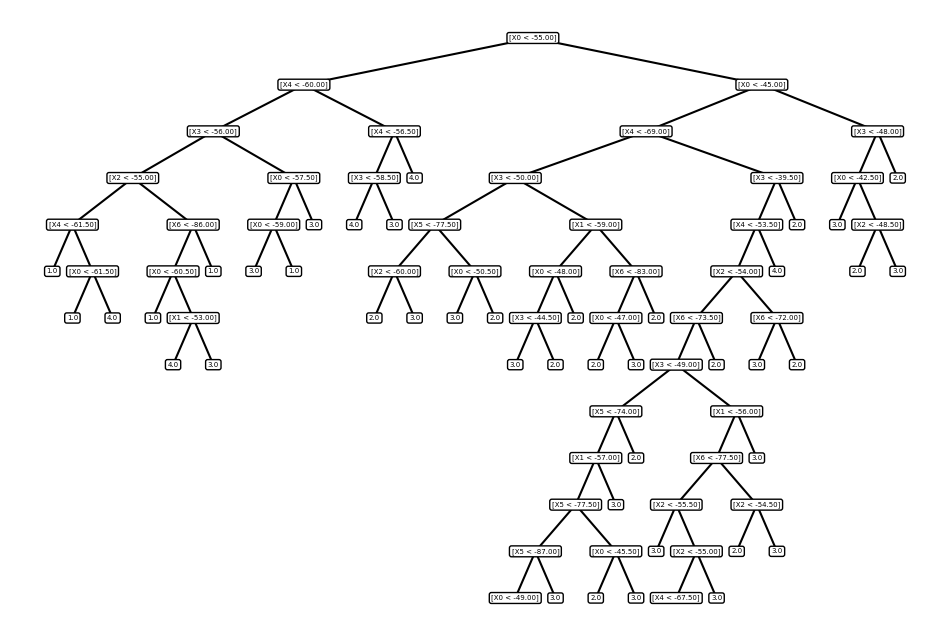

In [16]:
best_clean_tree = clean_metrics["best_tree"]
plt = best_clean_tree.visualise(1, best_clean_tree.depth)
plt.show()

#### Best tree on the noisy dataset

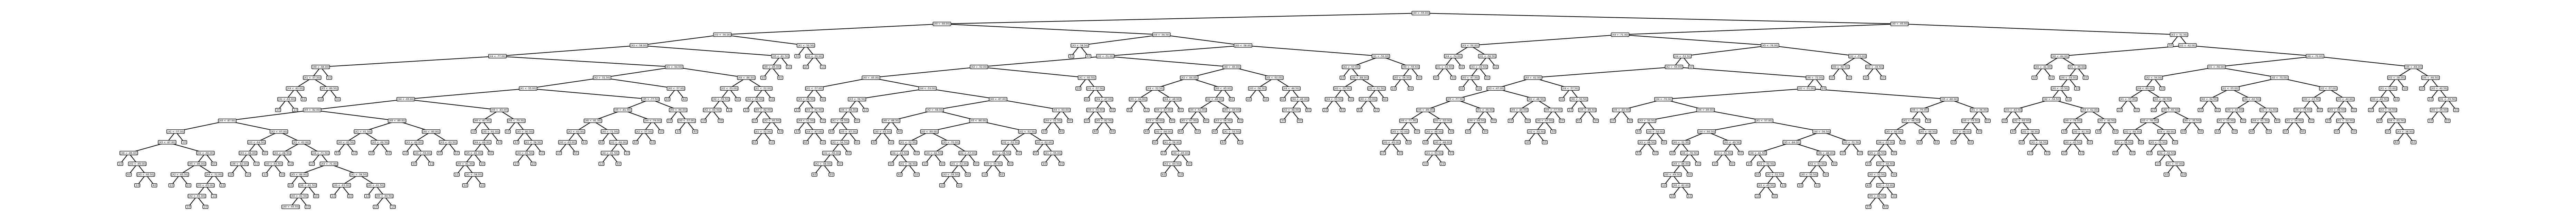

In [17]:
best_noisy_tree = noisy_metrics["best_tree"]
plt = best_noisy_tree.visualise(8, best_noisy_tree.depth)
plt.show()